# Green House Gas Emissions
In this notebook we will predict GHG-emissions based on social and governance readiness scores with inspiration from ND-GAIN indicators. 

Overview of the notebook structure
- Cleaning and assessing GHG-emission data 
- Log-transforming GHG data
- Combining GHG data with Predictor data
- Exploring correlations with the predictor data 
- Splitting the combined dataset in training, validation and testing data
    - With our outcome variable (GHG) lagged by 5 years
- Fitting baseline model (mean model)
- Fitting simple mixed effects model (time, population, countrysize)
- Fitting simple mixed effects models with each predictor seperately (time, population, countrysize, predictor_xyzab)
- Fitting theory driven mixed effects model of social (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting theory driven mixed effects model of governance (time, population, countrysize, predictor_x, predictor_y, predictor_z)
- Fitting a mixed effects decision tree model, random forest with all predictors
- Compare model predictions 


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import os

import pickle as pkl

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GroupShuffleSplit

# Cleaning and combining data 

In [14]:
#Read file 
df = pd.read_csv('Data/ghg-emissions.csv')

df.info

df.describe

<bound method NDFrame.describe of              iso                                     Country/Region    unit  \
0            CHN                                              China  MtCO2e   
1            USA                                      United States  MtCO2e   
2            IND                                              India  MtCO2e   
3            RUS                                             Russia  MtCO2e   
4            IDN                                          Indonesia  MtCO2e   
..           ...                                                ...     ...   
190          TUV                                             Tuvalu  MtCO2e   
191          NIU                                               Niue  MtCO2e   
192          FJI                                               Fiji  MtCO2e   
193  Data source                                      Climate Watch     NaN   
194     Data for  Location: World. Sectors/Subsectors: Total inc...     NaN   

        1990     

In [15]:
#clean data 
df.drop([193, 194], inplace=True)

melted_df = pd.melt(df, id_vars=['iso', 'Country/Region', 'unit'], var_name='Year', value_name='ghg')

#print(melted_df)

In [16]:
melted_df.describe()
melted_df.info()

,iso,Country/Region,unit,Year,ghg
count,5983,5983,5983,5983,5983.00
unique,193,193,1,31,4569.00
top,CHN,China,MtCO2e,1990,0.02
freq,31,31,5983,193,29.00


In [20]:
melted_df.replace('false', np.nan, inplace=True)
melted_df['Year'] = melted_df['Year'].astype(float)
melted_df['ghg'] = melted_df['ghg'].astype(float)

In [21]:

melted_df.dropna()
print(melted_df)

      iso Country/Region    unit    Year      ghg
0     CHN          China  MtCO2e  1990.0  2892.41
1     USA  United States  MtCO2e  1990.0  5448.74
2     IND          India  MtCO2e  1990.0  1020.11
3     RUS         Russia  MtCO2e  1990.0  2624.74
4     IDN      Indonesia  MtCO2e  1990.0  1140.84
...   ...            ...     ...     ...      ...
5978  COK   Cook Islands  MtCO2e  2020.0     0.07
5979  NRU          Nauru  MtCO2e  2020.0     0.05
5980  TUV         Tuvalu  MtCO2e  2020.0     0.02
5981  NIU           Niue  MtCO2e  2020.0     0.00
5982  FJI           Fiji  MtCO2e  2020.0    -0.81

[5983 rows x 5 columns]


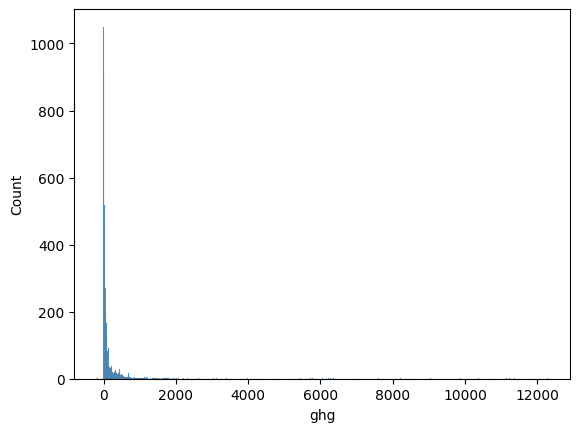

In [26]:
sns.histplot(data=melted_df, x='ghg', binwidth=10)
plt.show()

We need to transform our variable, so that the most polluting countries don't weigh to much. 

In [27]:
# Adding a small value to each value in 'ghg' column to avoid logarithm of zero
melted_df['log_ghg'] = np.log(melted_df['ghg'] + 1e-20)

# Check the result
print(melted_df.head())




   iso Country/Region    unit    Year      ghg   log_ghg
0  CHN          China  MtCO2e  1990.0  2892.41  7.969845
1  USA  United States  MtCO2e  1990.0  5448.74  8.603140
2  IND          India  MtCO2e  1990.0  1020.11  6.927666
3  RUS         Russia  MtCO2e  1990.0  2624.74  7.872737
4  IDN      Indonesia  MtCO2e  1990.0  1140.84  7.039520


C:\Users\marc1\AppData\Roaming\Python\Python310\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


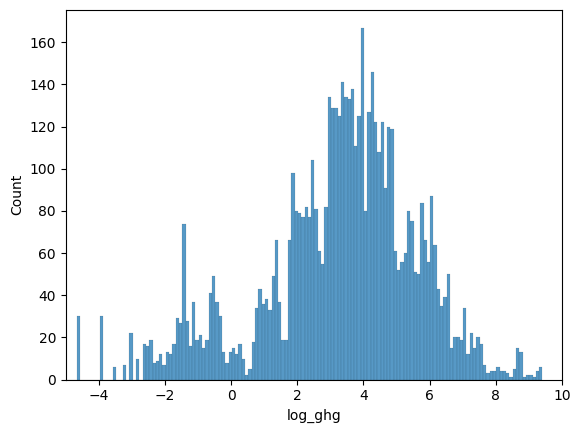

In [28]:
sns.histplot(data=melted_df, x='log_ghg', binwidth=0.1)
# Setting x-axis limit
plt.xlim(left=-5)
plt.xlim(right=10)
plt.show()

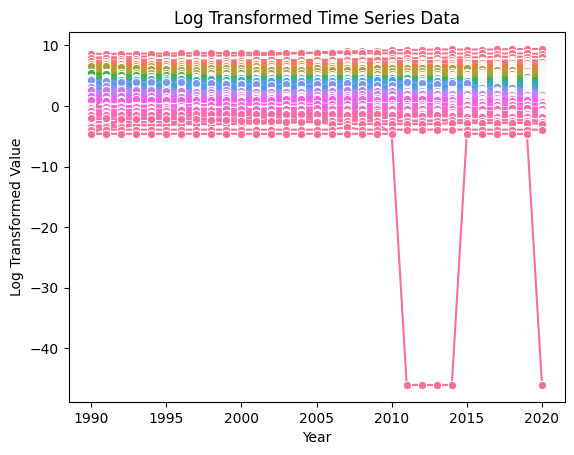

In [29]:
sns.lineplot(data=melted_df, x='Year', y='log_ghg', hue='iso', marker='o', legend=False)

# Add title and labels
plt.title('Log Transformed Time Series Data')
plt.xlabel('Year')
plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

### Add predictors to our GHG-dataset

In [13]:
#Read predictor file 

pred = pd.read_excel('git_data\predictor_data.xlsx')

display(pred)

,Country Name,Country Code,Year,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,Aruba,ABW,1960,54608.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,1960,130692579.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,AFG,1960,8622466.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Africa Western and Central,AFW,1960,97256290.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Angola,AGO,1960,5357195.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17769,Swaziland,SWZ,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.569174
17770,"Tanzania, United Republic of",TZA,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.751511
17771,Turkey,TUR,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.352290
17772,"Venezuela, Bolivarian Republic o",VEN,2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.478761


In [30]:
melted_df = melted_df.rename(columns={'iso': 'Country Code'})

print(melted_df)
display(melted_df)

     Country Code Country/Region    unit    Year      ghg    log_ghg
0             CHN          China  MtCO2e  1990.0  2892.41   7.969845
1             USA  United States  MtCO2e  1990.0  5448.74   8.603140
2             IND          India  MtCO2e  1990.0  1020.11   6.927666
3             RUS         Russia  MtCO2e  1990.0  2624.74   7.872737
4             IDN      Indonesia  MtCO2e  1990.0  1140.84   7.039520
...           ...            ...     ...     ...      ...        ...
5978          COK   Cook Islands  MtCO2e  2020.0     0.07  -2.659260
5979          NRU          Nauru  MtCO2e  2020.0     0.05  -2.995732
5980          TUV         Tuvalu  MtCO2e  2020.0     0.02  -3.912023
5981          NIU           Niue  MtCO2e  2020.0     0.00 -46.051702
5982          FJI           Fiji  MtCO2e  2020.0    -0.81        NaN

[5983 rows x 6 columns]


,Country Code,Country/Region,unit,Year,ghg,log_ghg
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140
2,IND,India,MtCO2e,1990.0,1020.11,6.927666
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520
...,...,...,...,...,...,...
5978,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260
5979,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732
5980,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023
5981,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702


In [31]:
ghg_full = pd.merge(melted_df, pred, on = ['Year', 'Country Code'], how = 'inner')
ghg_full = ghg_full.drop(columns=['Country Name'])

print(ghg_full)
display(ghg_full)

     Country Code Country/Region    unit    Year      ghg    log_ghg  \
0             CHN          China  MtCO2e  1990.0  2892.41   7.969845   
1             USA  United States  MtCO2e  1990.0  5448.74   8.603140   
2             IND          India  MtCO2e  1990.0  1020.11   6.927666   
3             RUS         Russia  MtCO2e  1990.0  2624.74   7.872737   
4             IDN      Indonesia  MtCO2e  1990.0  1140.84   7.039520   
...           ...            ...     ...     ...      ...        ...   
6746          COK   Cook Islands  MtCO2e  2020.0     0.07  -2.659260   
6747          NRU          Nauru  MtCO2e  2020.0     0.05  -2.995732   
6748          TUV         Tuvalu  MtCO2e  2020.0     0.02  -3.912023   
6749          NIU           Niue  MtCO2e  2020.0     0.00 -46.051702   
6750          FJI           Fiji  MtCO2e  2020.0    -0.81        NaN   

      Population, total  Land area (sq. km)    WGI VA    WGI PS    WGI GE  \
0          1.135185e+09           9388250.0       NaN     

,Country Code,Country/Region,unit,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,Education,Innovation,Social Inequality,ICT,Health
0,CHN,China,MtCO2e,1990.0,2892.41,7.969845,1.135185e+09,9388250.0,NaN,NaN,NaN,NaN,NaN,NaN,3.001490,5832.0,8.3,NaN,NaN
1,USA,United States,MtCO2e,1990.0,5448.74,8.603140,2.496230e+08,9158960.0,NaN,NaN,NaN,NaN,NaN,NaN,69.676811,90643.0,5.6,NaN,NaN
2,IND,India,MtCO2e,1990.0,1020.11,6.927666,8.704522e+08,2973190.0,NaN,NaN,NaN,NaN,NaN,NaN,5.851950,1147.0,NaN,NaN,NaN
3,RUS,Russia,MtCO2e,1990.0,2624.74,7.872737,1.479694e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.920052,NaN,NaN,NaN,NaN
4,IDN,Indonesia,MtCO2e,1990.0,1140.84,7.039520,1.821599e+08,1811570.0,NaN,NaN,NaN,NaN,NaN,NaN,8.385050,NaN,8.8,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6746,COK,Cook Islands,MtCO2e,2020.0,0.07,-2.659260,NaN,NaN,1.069792,1.151947,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6747,NRU,Nauru,MtCO2e,2020.0,0.05,-2.995732,1.231500e+04,20.0,0.535820,0.776041,0.145207,-0.083868,-0.103150,0.599187,NaN,NaN,NaN,NaN,0.553662
6748,TUV,Tuvalu,MtCO2e,2020.0,0.02,-3.912023,1.106900e+04,30.0,1.173426,1.218199,-0.430198,-0.317362,0.650381,0.484759,NaN,NaN,NaN,NaN,0.605705
6749,NIU,Niue,MtCO2e,2020.0,0.00,-46.051702,NaN,NaN,1.267860,1.362529,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
ghg_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6751 entries, 0 to 6750
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country Code        6751 non-null   object 
 1   Country/Region      6751 non-null   object 
 2   unit                6751 non-null   object 
 3   Year                6751 non-null   float64
 4   ghg                 6750 non-null   float64
 5   log_ghg             6662 non-null   float64
 6   Population, total   5921 non-null   float64
 7   Land area (sq. km)  5797 non-null   float64
 8   WGI VA              4117 non-null   float64
 9   WGI PS              4073 non-null   float64
 10  WGI GE              4038 non-null   float64
 11  WGI RQ              4041 non-null   float64
 12  WGI RL              4114 non-null   float64
 13  WGI CC              4057 non-null   float64
 14  Education           3635 non-null   float64
 15  Innovation          2994 non-null   float64
 16  Social

### Save combined data

In [39]:
ghg_full.to_csv('git_data\GHG-modelling.csv', index=False)

# Modelling GHG data 


### Assessing data 

Our full GHG-dataset does contain a significant amount of Na's. Since the linear regression dont handle Na's well, we have decided to drop countries that contains Na's. This leave us with 102 countries for GHG analysis. 

In [2]:
ghg_full = pd.read_csv('git_data\GHG-modelling.csv')
display(ghg_full)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


In [3]:
# Initialize an empty list to store the countries with all NaNs in at least one predictor column
countries_with_all_nans = []
# Initialize an empty list to store the removed countries
removed_countries = []

# Filter the dataset to only include rows where 'Year' is between 1996 and 2020
ghg_full_filtered = ghg_full[(ghg_full['Year'] >= 1996) & (ghg_full['Year'] <= 2020)]

# Identify countries with NaN in 'log_ghg' for years other than 1997 and 1999
countries_with_nan = ghg_full_filtered[
    (ghg_full_filtered['Year'] != 1997) & 
    (ghg_full_filtered['Year'] != 1999) & 
    (ghg_full_filtered['log_ghg'].isna())
]['Country Code'].unique()

# Filter out these countries from the dataset
ghg_full_filtered = ghg_full_filtered[~ghg_full_filtered['Country Code'].isin(countries_with_nan)]

# Define the non-predictor columns
non_predictor_columns = [
    'Country Code', 'Country/Region', 'unit', 'Year', 'ghg', 'log_ghg', 'Country Name', 'Education', 'Innovation', 'Social Inequality'
]

# Determine the number of predictors by excluding non-predictor columns
predictor_columns = ghg_full_filtered.columns.difference(non_predictor_columns)

# Calculate the threshold (more than half of the predictors)
threshold = len(predictor_columns) / 2

# Filter out rows where more than half of the predictors have NaN values
ghg_full_filtered = ghg_full_filtered[ghg_full_filtered[predictor_columns].isnull().sum(axis=1) <= threshold]

# Remove rows with 'Country Code' equal to 'NIU'
ghg_full_filtered = ghg_full_filtered[ghg_full_filtered['Country Code'] != 'NIU']

# Loop through each predictor column
for predictor_column in predictor_columns:
    # Group the data by country and check if all values in the current predictor column are NaN
    countries_with_nans = ghg_full_filtered.groupby('Country Code')[predictor_column].apply(lambda x: x.isnull().all())
    
    # Add countries with all NaNs in the current predictor column to the list
    countries_with_all_nans.extend(countries_with_nans[countries_with_nans].index.tolist())

# Remove duplicate countries from the list
countries_with_all_nans = list(set(countries_with_all_nans))

# Add removed countries to the list
removed_countries.extend(countries_with_all_nans)

# Remove countries with all NaNs in at least one predictor column from the dataset
ghg_full_filtered = ghg_full_filtered[~ghg_full_filtered['Country Code'].isin(countries_with_all_nans)]

# Display the removed countries
print("Countries removed using country code:", removed_countries)

display(countries_with_nan)
# Display the filtered dataset
display(ghg_full_filtered)

Countries removed using country code: []


array([], dtype=object)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


In [4]:
print(len(ghg_full_filtered['Country Code'].unique()))
print(ghg_full_filtered.isna().sum())


152
Country Code          0
Country/Region        0
Year                  0
ghg                   0
log_ghg               0
Population, total     0
Land area (sq. km)    0
WGI VA                0
WGI PS                0
WGI GE                0
WGI RQ                0
WGI RL                0
WGI CC                0
ICT                   0
Health                0
dtype: int64


In [52]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Separate the data by country
grouped_data = ghg_full_filtered.groupby('Country Code')

non_predictor_columns = [
    'Country Code', 'Country/Region', 'unit', 'Year', 'ghg', 'log_ghg', 'Education', 'Innovation', 'Social Inequality']

# Initialize an empty list to store imputed data frames
imputed_data_frames = []

# Iterate over each group and perform imputation
for country_code, group in grouped_data:
    # Drop non-predictor columns for imputation
    data_for_imputation = group.drop(columns=non_predictor_columns)

    # Initialize the IterativeImputer
    imputer = IterativeImputer(random_state=42)

    # Fit and transform the imputer on the data
    imputed_data = imputer.fit_transform(data_for_imputation)

    # Print shapes for debugging
    print("Shape of data_for_imputation:", data_for_imputation.shape)
    print("Shape of imputed_data:", imputed_data.shape)

    # Convert the imputed data back to DataFrame
    imputed_group = pd.DataFrame(imputed_data, columns=data_for_imputation.columns)

    # Reset index of the imputed group
    imputed_group.reset_index(drop=True, inplace=True)

    # Merge back the non-predictor columns with the imputed data
    imputed_group = pd.concat([group[non_predictor_columns].reset_index(drop=True), imputed_group], axis=1)

    # Append the imputed group to the list
    imputed_data_frames.append(imputed_group)

# Combine all the imputed data frames into one
ghg_full_imputed = pd.concat(imputed_data_frames, ignore_index=True)

# Display the imputed dataset
#display(ghg_full_imputed)

Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape of data_for_imputation: (22, 10)
Shape of imputed_data: (22, 10)
Shape 

In [7]:
# Verify the imputed data
print(ghg_full_imputed.isna().sum())

Country Code          0
Country/Region        0
Year                  0
ghg                   0
log_ghg               0
Population, total     0
Land area (sq. km)    0
WGI VA                0
WGI PS                0
WGI GE                0
WGI RQ                0
WGI RL                0
WGI CC                0
ICT                   0
Health                0
dtype: int64


In [9]:
ghg = ghg_full_imputed.drop(columns=['unit', 'Education', 'Innovation', 'Social Inequality'])
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


In [12]:
#Defining the number of years to lag
lag_years = 4

#Creating the new column 'lagged_ghg' and initializing with NaN
ghg['lagged_ghg'] = pd.NA

#Iterating over each row
for i in range(len(ghg)):
    country = ghg.loc[i, 'Country Code']
    year = ghg.loc[i, 'Year']

    correct_year = year + lag_years
    
    #Finding the row where the country is the same and the year is 'year + lag_years'
    lagged_row = ghg[(ghg['Country Code'] == country) & (ghg['Year'] == correct_year)]
    
    #print(lagged_row['ghg'])
    #If such a row exists, assign its 'Value' to the 'Lagged_Value' of the current row
    if not lagged_row.empty:
        ghg.loc[i, 'lagged_ghg'] = lagged_row['log_ghg'].values[0]

#Display the new dataframe 
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,Zimbabwe,2016.0,115.32,4.747711,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298,4.729156
3340,ZWE,Zimbabwe,2017.0,115.00,4.744932,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267,<NA>
3341,ZWE,Zimbabwe,2018.0,116.76,4.760121,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913,<NA>
3342,ZWE,Zimbabwe,2019.0,116.03,4.753849,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938,<NA>


In [13]:
#Checking if the lagged is correct 
print(ghg[(ghg['Country Code'] == 'ZWE') & (ghg['Year'] == 2000.0)]['log_ghg'])

print(ghg[(ghg['Country Code'] == 'ZWE') & (ghg['Year'] == 1996.0)]['lagged_ghg'])


3324    3.724729
Name: log_ghg, dtype: float64
3322    3.724729
Name: lagged_ghg, dtype: object


In [14]:
ghg['lagged_ghg'] = pd.to_numeric(ghg['lagged_ghg'])
ghg = ghg.rename(columns={'Land area (sq. km)':'land_area'})
ghg = ghg.rename(columns={'Population, total':'population'})
ghg = ghg.dropna()

display(ghg)
ghg.info()

,Country Code,Country/Region,Year,ghg,log_ghg,population,land_area,WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,ZWE,Zimbabwe,2012.0,42.23,3.743131,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,4.747711
3336,ZWE,Zimbabwe,2013.0,42.19,3.742183,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,4.744932
3337,ZWE,Zimbabwe,2014.0,40.34,3.697344,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,4.760121
3338,ZWE,Zimbabwe,2015.0,41.86,3.734331,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,4.753849


<class 'pandas.core.frame.DataFrame'>
Index: 2736 entries, 0 to 3339
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Code    2736 non-null   object 
 1   Country/Region  2736 non-null   object 
 2   Year            2736 non-null   float64
 3   ghg             2736 non-null   float64
 4   log_ghg         2736 non-null   float64
 5   population      2736 non-null   float64
 6   land_area       2736 non-null   float64
 7   WGI VA          2736 non-null   float64
 8   WGI PS          2736 non-null   float64
 9   WGI GE          2736 non-null   float64
 10  WGI RQ          2736 non-null   float64
 11  WGI RL          2736 non-null   float64
 12  WGI CC          2736 non-null   float64
 13  ICT             2736 non-null   float64
 14  Health          2736 non-null   float64
 15  lagged_ghg      2736 non-null   float64
dtypes: float64(14), object(2)
memory usage: 363.4+ KB


In [15]:
ghg.isna().sum()

Country Code      0
Country/Region    0
Year              0
ghg               0
log_ghg           0
population        0
land_area         0
WGI VA            0
WGI PS            0
WGI GE            0
WGI RQ            0
WGI RL            0
WGI CC            0
ICT               0
Health            0
lagged_ghg        0
dtype: int64

In [18]:
len(ghg['Country Code'].unique())

152

In [17]:
ghg.to_csv('git_data\GHG-modelling.csv', index=False)

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

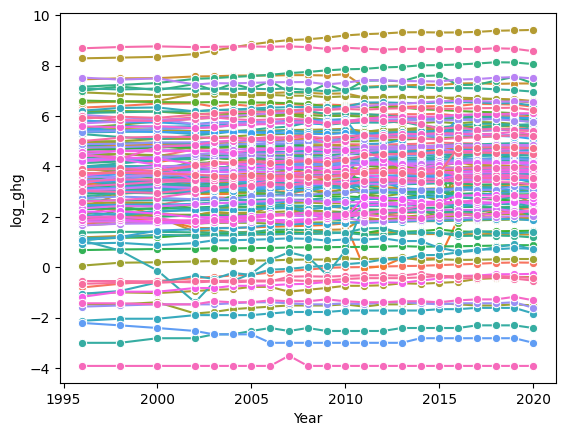

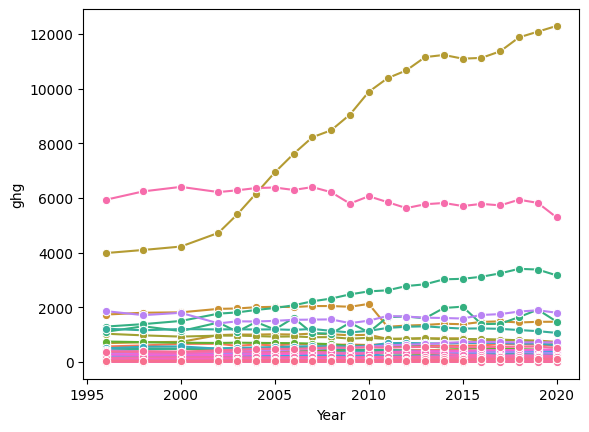

In [68]:
plt1 = sns.lineplot(data=ghg, x='Year', y='log_ghg', hue='Country Code', marker='o', legend=False)
plt.show()

plt2 = sns.lineplot(data=ghg, x='Year', y='ghg', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

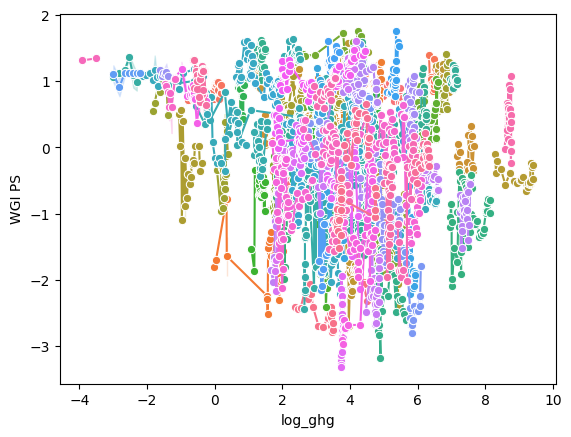

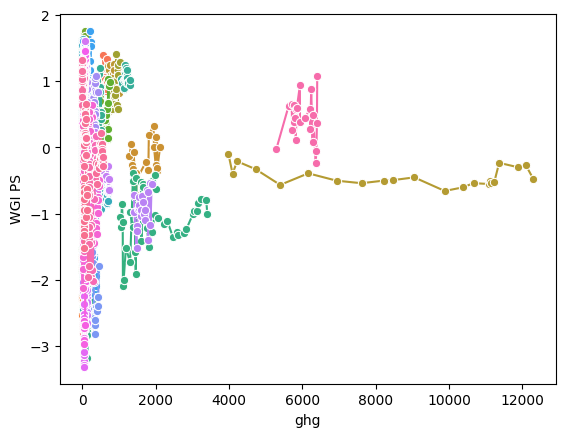

In [69]:
sns.lineplot(data=ghg, x='log_ghg', y='WGI PS', hue='Country Code', marker='o', legend=False)

# Add title and labels
#plt.title('Log Transformed Time Series Data')
#plt.xlabel('Year')
#plt.ylabel('Log Transformed Value')

# Show the plot
plt.show()

sns.lineplot(data=ghg, x='ghg', y='WGI PS', hue='Country Code', marker='o', legend=False)

# Show the plot
plt.show()

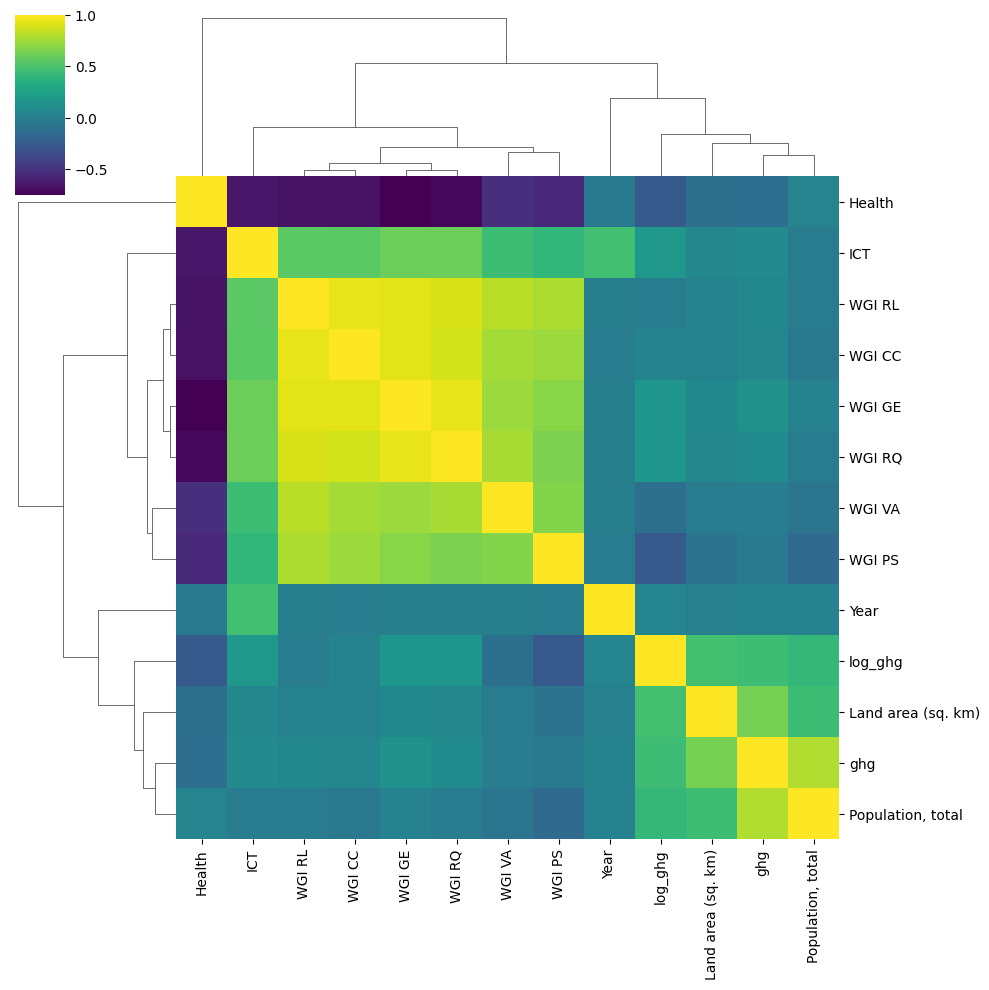

In [70]:
ghg_num = ghg[ghg.select_dtypes(exclude=['object']).columns]

sns.clustermap(ghg_num.corr(), cmap='viridis')
plt.show()

## Splitting the data set

In [21]:
from sklearn.model_selection import GroupShuffleSplit

In [19]:
display(ghg)

,Country Code,Country/Region,Year,ghg,log_ghg,population,land_area,WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg
0,AFG,Afghanistan,1996.0,10.84,2.383243,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793
1,AFG,Afghanistan,1998.0,12.68,2.540026,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068
2,AFG,Afghanistan,2000.0,11.82,2.469793,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024
3,AFG,Afghanistan,2002.0,15.38,2.733068,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895
4,AFG,Afghanistan,2003.0,16.08,2.777576,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,ZWE,Zimbabwe,2012.0,42.23,3.743131,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,4.747711
3336,ZWE,Zimbabwe,2013.0,42.19,3.742183,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,4.744932
3337,ZWE,Zimbabwe,2014.0,40.34,3.697344,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,4.760121
3338,ZWE,Zimbabwe,2015.0,41.86,3.734331,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,4.753849


In [74]:
#Defining the features (X) and the target variable (y)
X = ghg.drop(columns=['log_ghg', 'Country/Region', 'ghg', 'lagged_ghg']) 
y = ghg['lagged_ghg'] 

#Defining the group variable (Country)
groups = ghg['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

In [75]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1908, 12) (1908,)
Validation set shape: (414, 12) (414,)
Test set shape: (414, 12) (414,)


## Baseline Median Dummy Model 

- **Data Preparation:**
  - Import necessary libraries for numerical computations and model evaluation.
  - Convert the 'lagged_ghg' column in the dataset (`ghg_model`) to numeric data type.
  - Define a function `detect_outliers` to identify outliers using the Interquartile Range (IQR) method within each group of data.
  - Apply the outlier detection function to group the data by 'Country Code' and identify outliers.
  - Print the total number of outliers and the number of outliers per country.
  
- **Data Splitting:**
  - Define features (`X`) and the target variable (`y`) by excluding certain columns from the dataset.
  - Define the grouping variable (`groups`) based on 'Country Code'.
  - Initialize a GroupShuffleSplit object (`gss_outer`) to split the data into training and test sets while preserving groups.
  - Split the data into training and test sets, and further split the test set into validation and test sets using nested GroupShuffleSplit objects.
  - Print the shapes of the training, validation, and test sets.

- **Model Evaluation:**
  - Initialize a list (`performances`) to store performance metrics.
  - For each data split (train, val, test):
    - Calculate the median of 'lagged_ghg' for each country in the current split.
    - Merge the median values back to the current data split.
    - Use the median 'lagged_ghg' as predictions for the baseline model.
    - Calculate performance metrics (MAE, RMSE, MAPE, R2) for the baseline model on the current data split and append them to the `performances` list.

- **Performance Visualization:**
  - Print the performance metrics (MAE, RMSE, MAPE, R2) for each model split.
  - Visualize the performance metrics using scatterplots sorted by RMSE, MAPE, MAE, and R2 for each model split.

In [85]:
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
import pickle as pkl
from math import sqrt
import pandas as pd

In [72]:
ghg_model = ghg
ghg_model['lagged_ghg'] = pd.to_numeric(ghg_model['lagged_ghg'])

In [58]:
# Function to detect outliers using IQR method for a given group
def detect_outliers(group):
    Q1 = group['lagged_ghg'].quantile(0.25)
    Q3 = group['lagged_ghg'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['lagged_ghg'] < lower_bound) | (group['lagged_ghg'] > upper_bound)]

# Group by 'Country Code' and apply the outlier detection function
outliers = ghg_model.groupby('Country Code').apply(detect_outliers).reset_index(drop=True)

# Print the outliers
#print("Outliers in 'lagged_ghg' per 'Country Code':")
#print(outliers)

# Total number of outliers
total_outliers = outliers.shape[0]
print("\nTotal number of outliers:", total_outliers)

# Number of outliers per country
outliers_per_country = outliers.groupby('Country Code').size()
print("\nNumber of outliers per 'Country Code':")
print(outliers_per_country)
print(f'Number of countries with outliers: {len(outliers_per_country)}')



Total number of outliers: 60

Number of outliers per 'Country Code':
Country Code
AGO    1
ARG    1
ARM    2
ATG    1
BLR    1
BRN    2
BWA    2
CAF    1
CHN    2
CMR    3
DEU    1
DJI    2
DMA    3
DOM    1
GNB    1
GNQ    2
HND    1
IDN    2
ISR    4
JAM    2
KAZ    2
KEN    1
KIR    2
LSO    2
MHL    1
MOZ    1
MUS    1
NAM    2
NLD    1
NRU    2
PLW    1
PRY    1
SDN    1
SLV    1
TON    1
TTO    2
TUV    1
ZAF    2
dtype: int64
Number of countries with outliers: 38


In [79]:
#Defining the features (X) and the target variable (y)
X = ghg.drop(columns=['log_ghg', 'Country/Region', 'ghg']) 
y = ghg['lagged_ghg'] 

#Defining the group variable (Country)
groups = ghg['Country Code']

#Initializing the GroupShuffleSplit
gss_outer = GroupShuffleSplit(n_splits=1, test_size=0.30, random_state=42)

#Splitting the data into train and test sets
for train_index, test_index in gss_outer.split(X, y, groups):
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
    groups_test = groups.iloc[test_index]

    # Further split the test set into two parts
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=0.5, random_state=42)  # Adjust test_size as needed
    for test_index, val_index in gss_inner.split(X_test, y_test, groups_test):
        X_test, X_val = X_test.iloc[test_index], X_test.iloc[val_index]
        y_test, y_val = y_test.iloc[test_index], y_test.iloc[val_index]

In [80]:
# Print the shapes of training and test sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (1908, 13) (1908,)
Validation set shape: (414, 13) (414,)
Test set shape: (414, 13) (414,)


In [81]:
display(X_train)

,Country Code,Year,population,land_area,WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health,lagged_ghg
0,AFG,1996.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476,2.469793
1,AFG,1998.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476,2.733068
2,AFG,2000.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476,2.753024
3,AFG,2002.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897,2.855895
4,AFG,2003.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216,2.909084
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3335,ZWE,2012.0,13265331.0,386850.0,-1.471968,-0.778662,-1.373752,-1.871891,-1.630184,-1.381803,32.635170,0.640969,4.747711
3336,ZWE,2013.0,13555422.0,386850.0,-1.386220,-0.665950,-1.308181,-1.854899,-1.587261,-1.419667,34.527992,0.668198,4.744932
3337,ZWE,2014.0,13855753.0,386850.0,-1.256889,-0.713570,-1.279434,-1.892658,-1.441469,-1.404367,29.543350,0.667720,4.760121
3338,ZWE,2015.0,14154937.0,386850.0,-1.166087,-0.619207,-1.248707,-1.656233,-1.338473,-1.337617,31.214313,0.692355,4.753849


In [1]:
# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, y, nsplit, name in zip([X_train, X_val, X_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Calculate median lagged_ghg for each country in the current data split
    medians_split = x.groupby('Country Code')['lagged_ghg'].median().reset_index()
    medians_split.columns = ['Country Code', 'median_lagged_ghg']
    
    # Merge the median values back to the current data split
    x = x.merge(medians_split, on='Country Code', how='left')
    
    # Use the median_lagged_ghg as the prediction for the baseline model
    x['median_prediction'] = x['median_lagged_ghg']
    
    # Calculate performance metrics for the baseline model on the current data split
    mae = mean_absolute_error(y, x['median_prediction'])
    mse = mean_squared_error(y, x['median_prediction'])  # Calculate MSE
    rmse = np.sqrt(mse)  # Calculate RMSE
    mape = mean_absolute_percentage_error(y, x['median_prediction'])
    r2 = r2_score(y, x['median_prediction'])

    performances.append({
        'model': name,
        'split': nsplit,
        'mae': round(mae, 4),
        'rmse': round(rmse, 4),
        'mape': round(mape, 4),
        'r2': round(r2, 4)
    })


NameError: name 'X_train' is not defined

In [88]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.17
MAE:  0.1509
MAPE:  46628227747.2755
R2:  0.9813


Model:  X_val
Split:  val
RMSE:  0.17
MAE:  0.1298
MAPE:  0.0652
R2:  0.989


Model:  X_test
Split:  test
RMSE:  0.17
MAE:  0.1072
MAPE:  0.1501
R2:  0.9927




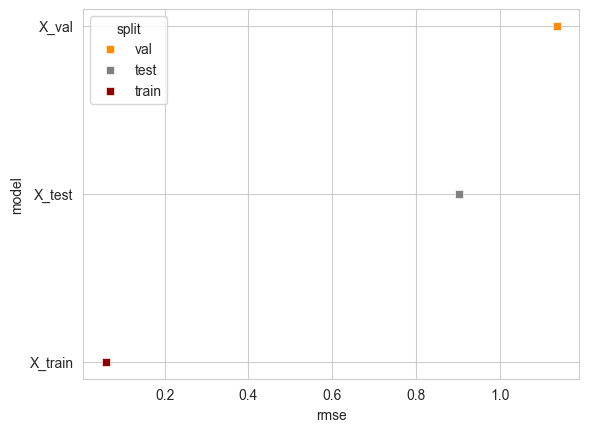

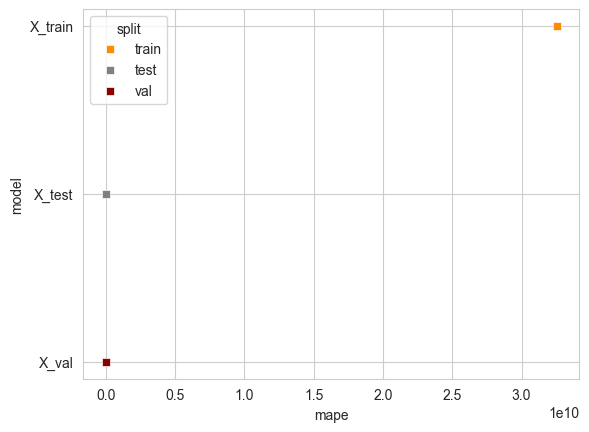

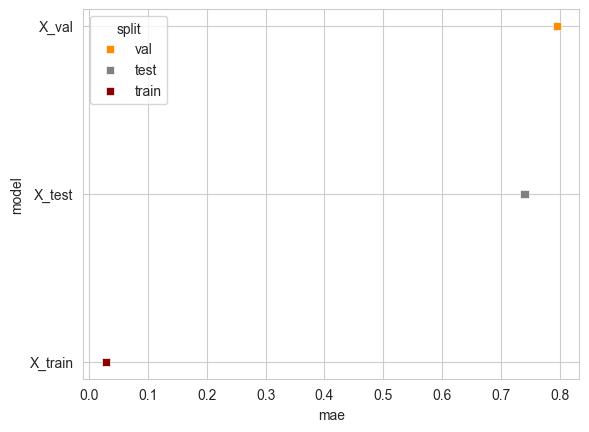

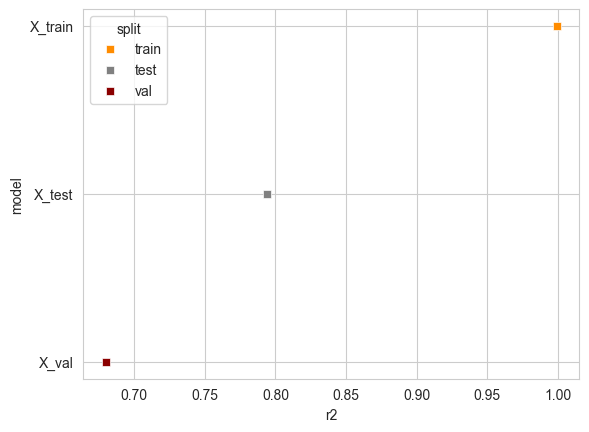

In [89]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

## Mixed Effects Linear Regressor (MELF)

**Governmental Readiness**
- A list named `performances` is initialized to store performance metrics.
- Theoretical predictors are selected by dropping certain columns from the training data (`X_train`) and fitting a linear regression model (`reg`) to predict the target variable (`y_train`).
- Performance metrics including R-squared (`r2`), root mean squared error (`rmse`), mean absolute error (`mae`), and mean absolute percentage error (`mape`) are calculated for the training, validation, and test datasets (`X_train`, `X_val`, `X_test`), and appended to the `performances` list.
- A DataFrame (`perf_df`) is created from the `performances` list, and the performance metrics are printed for each model split (train, val, test).
- Scatterplots are generated to visualize the performance metrics (`rmse`, `mape`, `mae`, `r2`) for each model split.

**Social Readiness**
- Similar steps are repeated for the social readiness section, where different columns are dropped from the training data (`X_train`) to fit a linear regression model (`reg`) predicting the target variable (`y_train`).
- Performance metrics are calculated and stored in the `performances` list, and then printed for each model split (train, val, test).
- Scatterplots are generated to visualize the performance metrics (`rmse`, `mape`, `mae`, `r2`) for each model split.

### Governmental Readiness

In [117]:
performances = []

#Now let's fit a linear model with only theoretical predictors
X_train_selected = X_train.drop(columns=['Country Code', 'WGI PS', 'WGI CC', 'WGI RQ', 'WGI RL', 'WGI GE', 'ICT', 'lagged_ghg'])

reg = LinearRegression().fit(X_train_selected, y_train)
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # Remove features from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI PS', 'WGI CC', 'WGI RQ', 'WGI RL', 'WGI GE', 'ICT', 'lagged_ghg'])
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': nsplit,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'r2': round(r2, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4)
    })

In [118]:
perf_df = pd.DataFrame(performances)

In [119]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  train
Split:  train
RMSE:  1.6601
MAE:  1.2405
MAPE:  7064679435141.328
R2:  0.4152


Model:  val
Split:  val
RMSE:  2.0346
MAE:  1.4981
MAPE:  1.1389
R2:  -0.0269


Model:  test
Split:  test
RMSE:  1.672
MAE:  1.4468
MAPE:  2.4983
R2:  0.2942




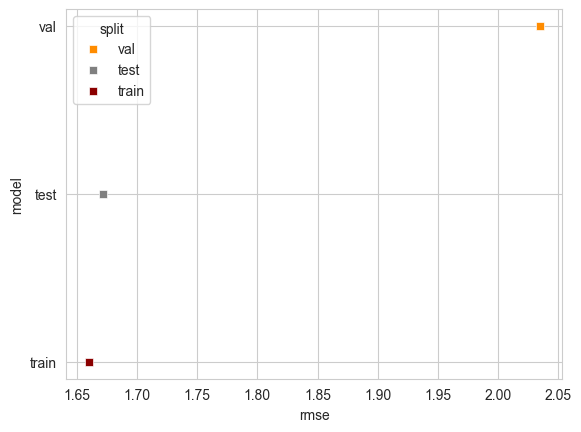

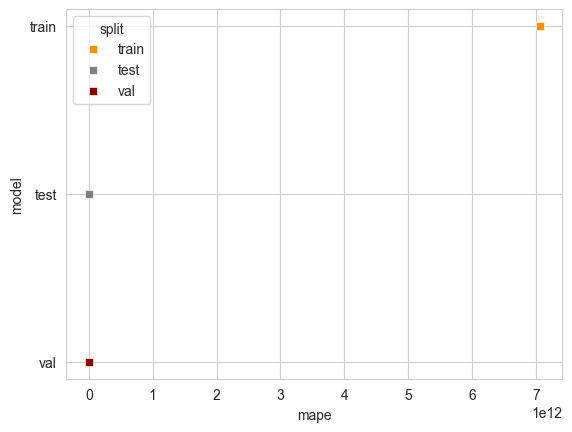

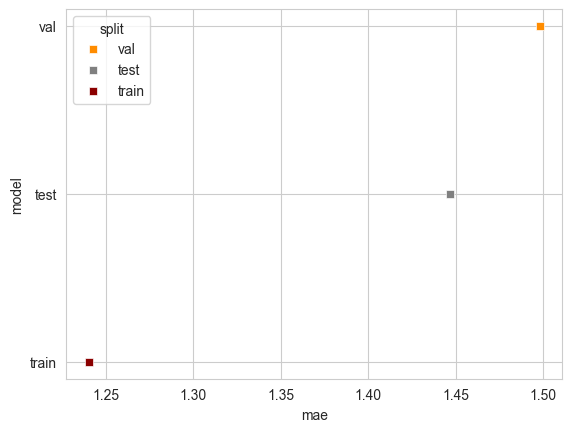

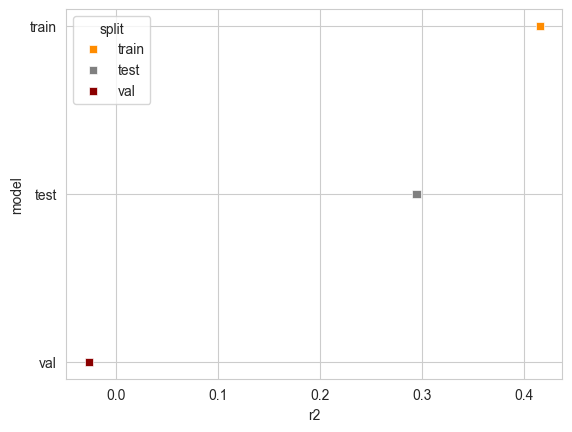

In [120]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

### Social Readiness

In [121]:
performances = []

#Now let's fit a linear model with only theoretical predictors
X_train_selected = X_train.drop(columns=['Country Code', 'WGI VA', 'WGI PS', 'WGI CC', 'ICT', 'Health', 'lagged_ghg'])

reg = LinearRegression().fit(X_train_selected, y_train)
for x,y,nsplit in zip([X_train, X_val, X_test],
                    [y_train, y_val, y_test],
                    ['train', 'val', 'test']):
    # Remove features from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI VA', 'WGI PS', 'WGI CC', 'ICT', 'Health', 'lagged_ghg'])
    preds = reg.predict(x_selected)
    
    # Calculate performance metrics
    r2 = r2_score(y, preds)
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    
    # Append performance metrics to the list
    performances.append({
        'model': nsplit,
        'split': nsplit,
        'rmse': round(rmse, 4),
        'r2': round(r2, 4),
        'mae': round(mae, 4),
        'mape': round(mape, 4)
    })

In [122]:
perf_df = pd.DataFrame(performances)

In [123]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  train
Split:  train
RMSE:  1.5644
MAE:  1.2111
MAPE:  5575933373683.535
R2:  0.4807


Model:  val
Split:  val
RMSE:  1.5864
MAE:  1.2255
MAPE:  0.8557
R2:  0.3757


Model:  test
Split:  test
RMSE:  1.739
MAE:  1.4028
MAPE:  2.9685
R2:  0.2365




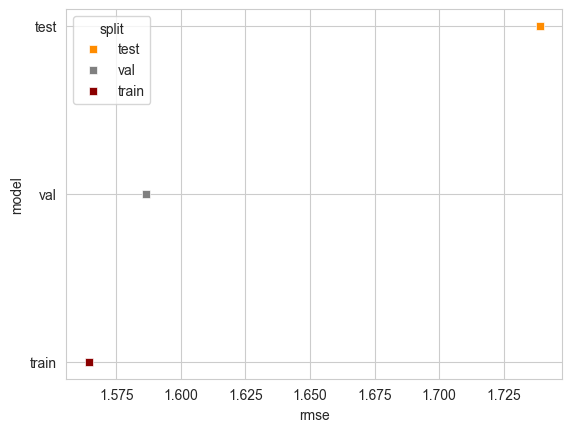

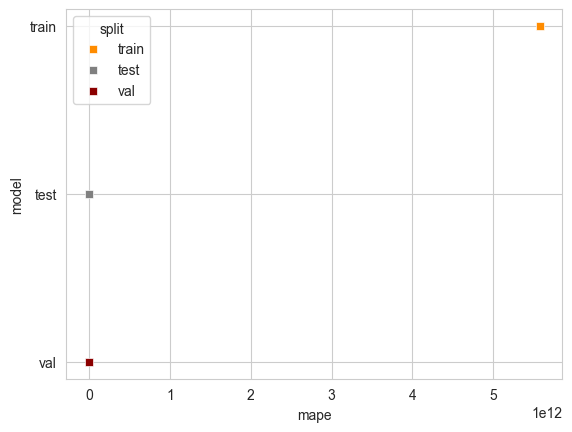

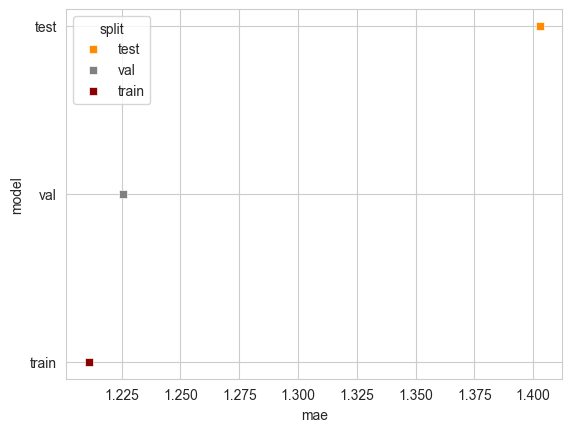

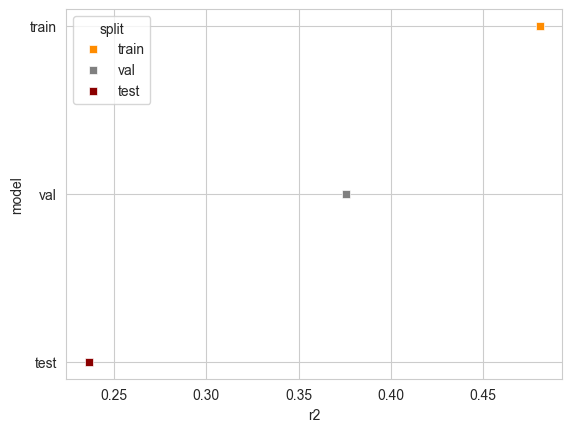

In [124]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

## Mixed Effects Linear Regressor (MERF)

- **Data Preparation**
  - Split datasets into `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`
  - Define random effects matrix `Z` using the 'Year' feature
  - Select features for training excluding the target and random effects columns
  - Assign clusters using 'Country Code'

- **Model Training**
  - Instantiate `MERF()` model
  - Fit the model with `X_train_selected`, `Z_train`, `clusters_train`, `y_train`

- **Performance Evaluation**
  - Evaluate on train, validation, and test sets
  - Metrics: RMSE, MAE, MAPE, R2
  - Store and print performance metrics for each dataset split

- **Performance Visualization**
  - Create scatter plots to visualize RMSE, MAE, MAPE, R2 for different splits using `sns.scatterplot`

- **SHAP Analysis**
  - Calculate SHAP values for the fixed effects model
  - Plot SHAP summary plot

- **Model Variants**
  - **Government Readiness Model**: Excludes 'Country Code', 'WGI VA', 'ICT', 'Health'
  - **Social Readiness Model**: Excludes 'Country Code', 'WGI PS', 'WGI GE', 'WGI RQ', 'WGI RL', 'WGI CC'

In [24]:
import merf
from merf import MERF
import numpy as np
import pickle as pkl
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import shap

c:\Users\marc1\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Combined MERF Model

In [25]:
# Initialize a list to store performance metrics
performances = []

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.iloc[:, 1:]

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7178.51782797483 at iteration 1.
INFO     [merf.py:307] Training GLL is -10569.067659999711 at iteration 2.
INFO     [merf.py:307] Training GLL is -10795.300285341385 at iteration 3.
INFO     [merf.py:307] Training GLL is -10699.940672822893 at iteration 4.
INFO     [merf.py:307] Training GLL is -10712.693310829132 at iteration 5.
INFO     [merf.py:307] Training GLL is -10807.93175562954 at iteration 6.
INFO     [merf.py:307] Training GLL is -10740.805573597769 at iteration 7.
INFO     [merf.py:307] Training GLL is -10723.649544899708 at iteration 8.
INFO     [merf.py:307] Training GLL is -10646.493308602969 at iteration 9.
INFO     [merf.py:307] Training GLL is -10579.501670092877 at iteration 10.
INFO     [merf.py:307] Training GLL is -10598.478672027213 at iteration 11.
INFO     [merf.py:307] Training GLL is -10608.12920811996 at iteration 12.
INFO     [merf.py:307] Training GLL is -10566.079565547154 at iteration 13.
INFO     [merf.py:307] Tr

In [26]:
print(performances)

[{'model': 'X_train', 'split': 'train', 'rmse': 0.0612, 'mae': 0.03, 'mape': 24747313265.88, 'r2': 0.9992}, {'model': 'X_val', 'split': 'val', 'rmse': 1.1178, 'mae': 0.7831, 'mape': 0.5864, 'r2': 0.6901}, {'model': 'X_test', 'split': 'test', 'rmse': 0.9155, 'mae': 0.7246, 'mape': 0.8035, 'r2': 0.7884}]


In [27]:
perf_df = pd.DataFrame(performances)

In [28]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.0612
MAE:  0.03
MAPE:  24747313265.88
R2:  0.9992


Model:  X_val
Split:  val
RMSE:  1.1178
MAE:  0.7831
MAPE:  0.5864
R2:  0.6901


Model:  X_test
Split:  test
RMSE:  0.9155
MAE:  0.7246
MAPE:  0.8035
R2:  0.7884




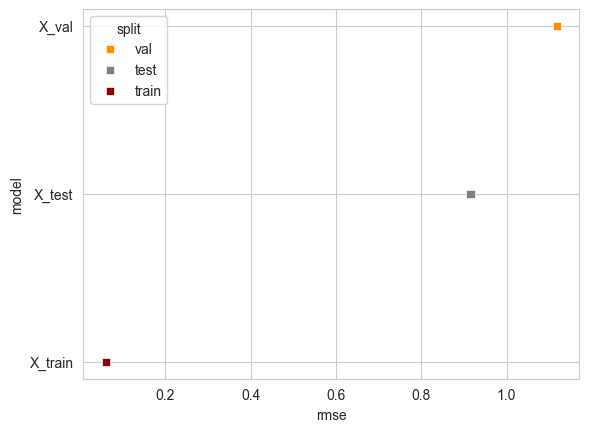

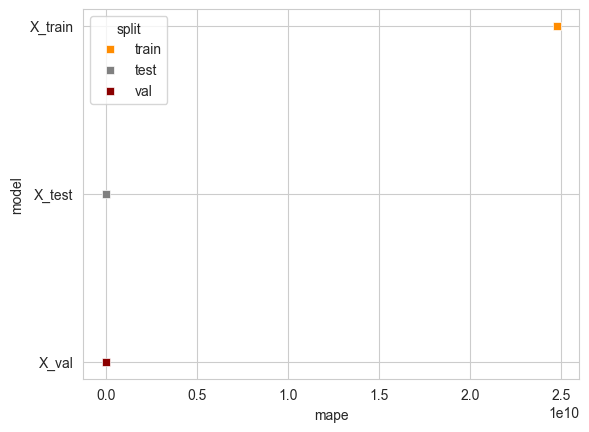

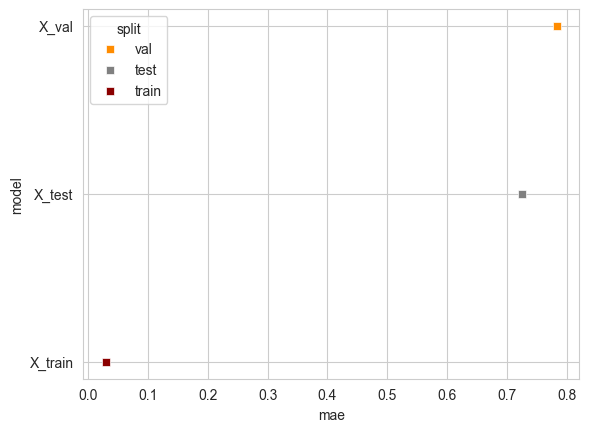

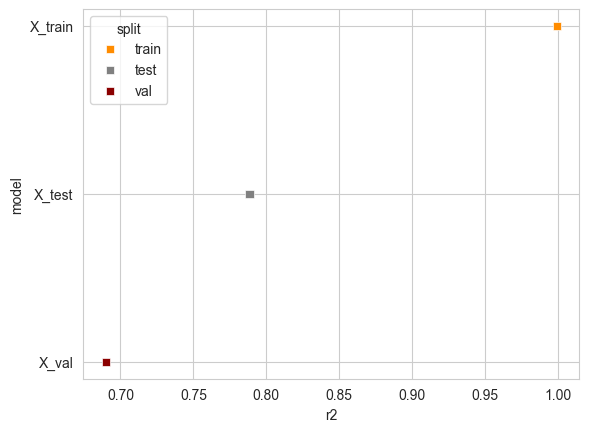

In [29]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

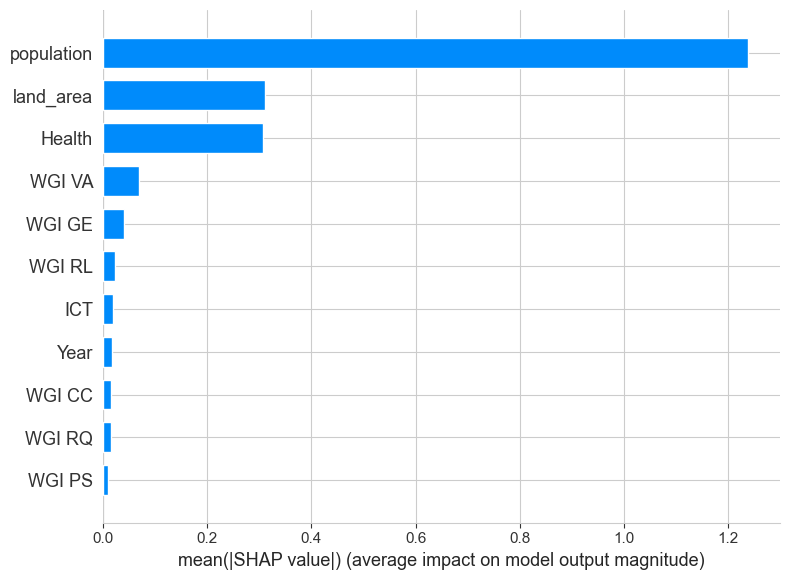

In [30]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Governmental Readiness MERF Model

In [31]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Government Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI VA', 'ICT', 'Health'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI VA', 'ICT', 'Health'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7099.742954921578 at iteration 1.
INFO     [merf.py:307] Training GLL is -10236.020279191885 at iteration 2.
INFO     [merf.py:307] Training GLL is -10399.062442399067 at iteration 3.
INFO     [merf.py:307] Training GLL is -10391.110955095553 at iteration 4.
INFO     [merf.py:307] Training GLL is -10309.139558466399 at iteration 5.
INFO     [merf.py:307] Training GLL is -10331.058030111413 at iteration 6.
INFO     [merf.py:307] Training GLL is -10377.577632178445 at iteration 7.
INFO     [merf.py:307] Training GLL is -10380.1609589668 at iteration 8.
INFO     [merf.py:307] Training GLL is -10222.239938076369 at iteration 9.
INFO     [merf.py:307] Training GLL is -10367.29996876608 at iteration 10.
INFO     [merf.py:307] Training GLL is -10324.767635707522 at iteration 11.
INFO     [merf.py:307] Training GLL is -10263.37066018715 at iteration 12.
INFO     [merf.py:307] Training GLL is -10360.927301535872 at iteration 13.
INFO     [merf.py:307] Tra

In [32]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.0633
MAE:  0.0327
MAPE:  14448240920.6841
R2:  0.9992


Model:  X_val
Split:  val
RMSE:  1.1946
MAE:  0.912
MAPE:  0.6728
R2:  0.646


Model:  X_test
Split:  test
RMSE:  0.8994
MAE:  0.6976
MAPE:  0.8256
R2:  0.7958




In [33]:
perf_df = pd.DataFrame(performances)

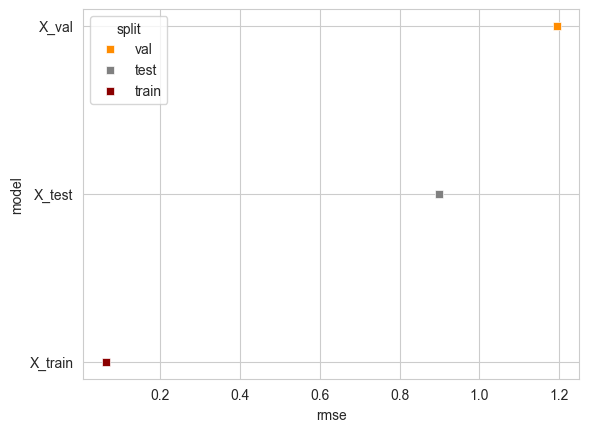

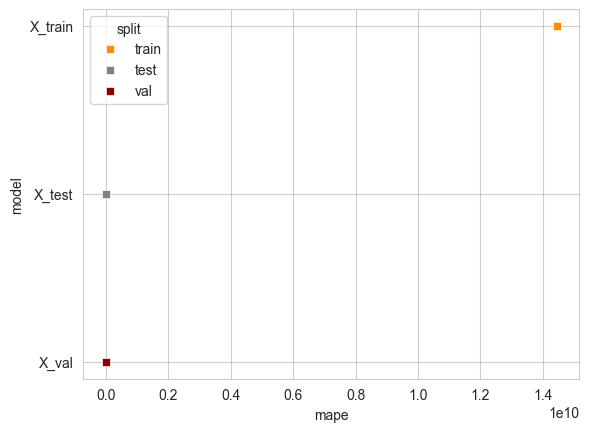

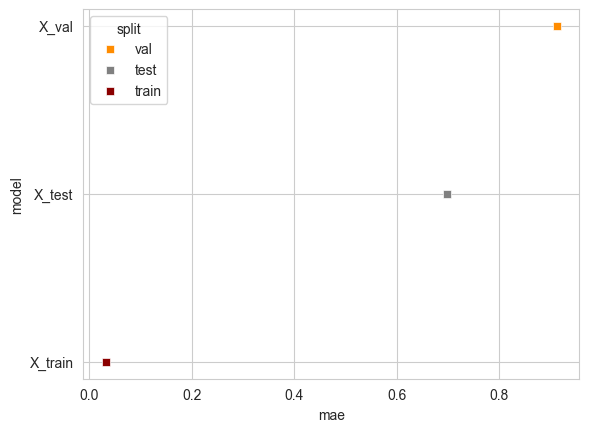

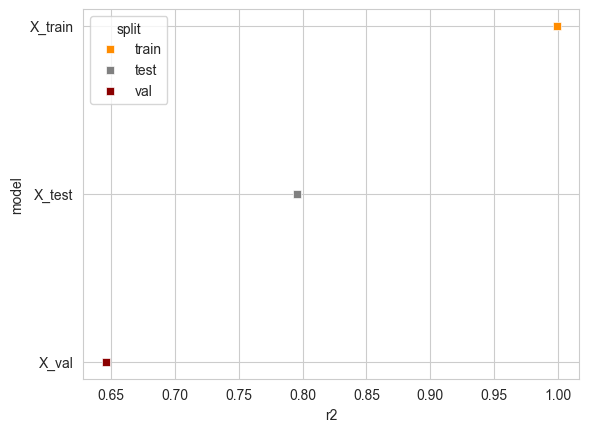

In [34]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

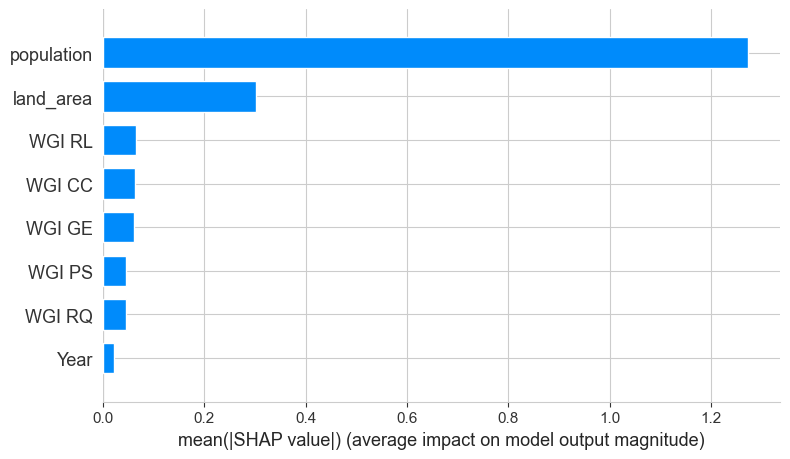

In [35]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")

### Social Readiness MERF Model

In [180]:
display(X_train)

,Country Code,Year,"Population, total",Land area (sq. km),WGI VA,WGI PS,WGI GE,WGI RQ,WGI RL,WGI CC,ICT,Health
0,AFG,1996.0,17106595.0,652230.0,-1.908540,-2.417310,-2.175167,-2.090330,-1.788075,-1.291705,6.491741,0.755476
1,AFG,1998.0,18493132.0,652230.0,-2.039301,-2.427355,-2.102292,-2.062872,-1.734887,-1.176012,7.493740,0.755476
2,AFG,2000.0,19542982.0,652230.0,-2.031417,-2.438969,-2.173946,-2.080253,-1.780661,-1.271724,8.252428,0.755476
3,AFG,2002.0,21000256.0,652230.0,-1.433421,-2.035034,-1.587687,-1.811546,-1.673473,-1.251137,9.305547,0.754897
4,AFG,2003.0,22645130.0,652230.0,-1.177571,-2.198372,-1.175768,-1.463108,-1.558294,-1.344180,10.494238,0.704216
...,...,...,...,...,...,...,...,...,...,...,...,...
3339,ZWE,2016.0,14452704.0,386850.0,-1.178460,-0.620810,-1.257999,-1.694922,-1.390663,-1.288441,30.802734,0.714298
3340,ZWE,2017.0,14751101.0,386850.0,-1.195905,-0.710431,-1.282108,-1.583454,-1.396204,-1.298485,32.864358,0.714267
3341,ZWE,2018.0,15052184.0,386850.0,-1.136798,-0.721038,-1.297906,-1.525652,-1.292463,-1.246001,29.632238,0.710913
3342,ZWE,2019.0,15354608.0,386850.0,-1.163669,-0.943286,-1.319774,-1.486515,-1.303515,-1.271190,29.667663,0.710938


In [36]:
# Assuming you have already defined your datasets: X_train, X_val, X_test, y_train, y_val, y_test
# Also assuming you have a variable Z_train for random effects
performances = []

# Define the model name
model_name = "Social Readiness MERF"

# Example for random effects matrix Z (this should be your actual random effects data)
Z_train = X_train['Year'].values.reshape(-1, 1)
Z_val = X_val['Year'].values.reshape(-1, 1)
Z_test = X_test['Year'].values.reshape(-1, 1)

X_train_selected = X_train.drop(columns=['Country Code', 'WGI PS','WGI GE','WGI RQ','WGI RL','WGI CC'])

# Assign country codes as cluster labels
clusters_train = X_train['Country Code']

# Fit the MERF model
merf = MERF()
merf.fit(X_train_selected, Z_train, clusters_train, y_train)

# Save the model
with open('ghg_MERF.pkl', 'wb') as file:
    pkl.dump(merf, file)

# Initialize a list to store performance metrics
performances = []

# Evaluate the model on train, validation, and test sets
for x, z, y, nsplit, name in zip([X_train, X_val, X_test], [Z_train, Z_val, Z_test], [y_train, y_val, y_test], ['train', 'val', 'test'], ['X_train', 'X_val', 'X_test']):
    # Remove 'Country Code' feature from the input data
    x_selected = x.drop(columns=['Country Code', 'WGI PS','WGI GE','WGI RQ','WGI RL','WGI CC'])
    
    # Define clusters based on country codes
    clusters = x['Country Code']
    
    # Predict using the MERF model
    preds = merf.predict(x_selected, z, clusters)
    
    # Calculate performance metrics
    rmse = np.sqrt(mean_squared_error(y, preds))
    mae = mean_absolute_error(y, preds)
    mape = mean_absolute_percentage_error(y, preds)
    r2 = r2_score(y, preds)
    
    performances.append({
        'model': name,
        'split': nsplit,
        'rmse': rmse.round(4),
        'mae': mae.round(4),
        'mape': mape.round(4),
        'r2': r2.round(4)})

# Print the performance metrics
#for performance in performances:
#    print(performance)

INFO     [merf.py:307] Training GLL is -7150.603267522795 at iteration 1.
INFO     [merf.py:307] Training GLL is -10584.507656137437 at iteration 2.
INFO     [merf.py:307] Training GLL is -10814.098111063371 at iteration 3.
INFO     [merf.py:307] Training GLL is -10852.849606007834 at iteration 4.
INFO     [merf.py:307] Training GLL is -10858.6996224962 at iteration 5.
INFO     [merf.py:307] Training GLL is -10857.37937545825 at iteration 6.
INFO     [merf.py:307] Training GLL is -10862.11613356829 at iteration 7.
INFO     [merf.py:307] Training GLL is -10931.887257721226 at iteration 8.
INFO     [merf.py:307] Training GLL is -10809.717521147106 at iteration 9.
INFO     [merf.py:307] Training GLL is -10850.310349367568 at iteration 10.
INFO     [merf.py:307] Training GLL is -10770.94290417628 at iteration 11.
INFO     [merf.py:307] Training GLL is -10794.438990515955 at iteration 12.
INFO     [merf.py:307] Training GLL is -10836.369600040023 at iteration 13.
INFO     [merf.py:307] Trai

In [37]:
for performance in performances:
    print("Model: ", performance['model'])
    print("Split: ", performance['split'])
    print("RMSE: ", performance['rmse'])
    print("MAE: ", performance['mae'])
    print("MAPE: ", performance['mape'])
    print("R2: ", performance['r2'])
    print("\n")

Model:  X_train
Split:  train
RMSE:  0.0599
MAE:  0.0283
MAPE:  32549947462.8236
R2:  0.9992


Model:  X_val
Split:  val
RMSE:  1.1358
MAE:  0.7954
MAPE:  0.604
R2:  0.68


Model:  X_test
Split:  test
RMSE:  0.9031
MAE:  0.7406
MAPE:  0.8568
R2:  0.7941




In [38]:
perf_df = pd.DataFrame(performances)

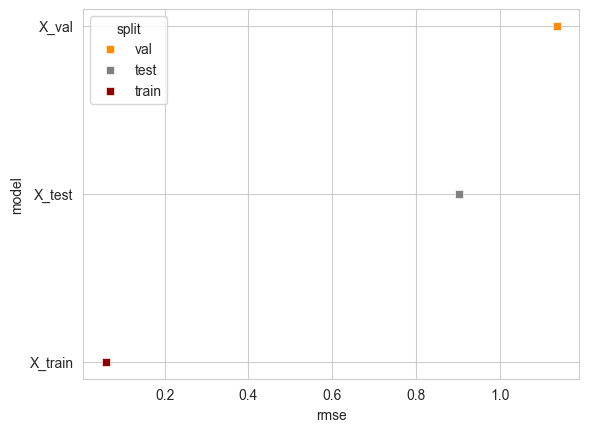

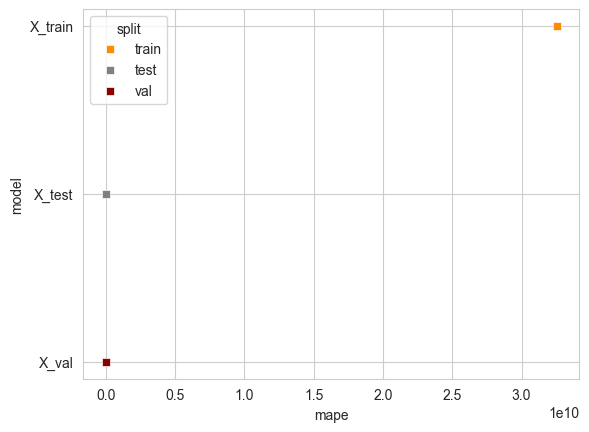

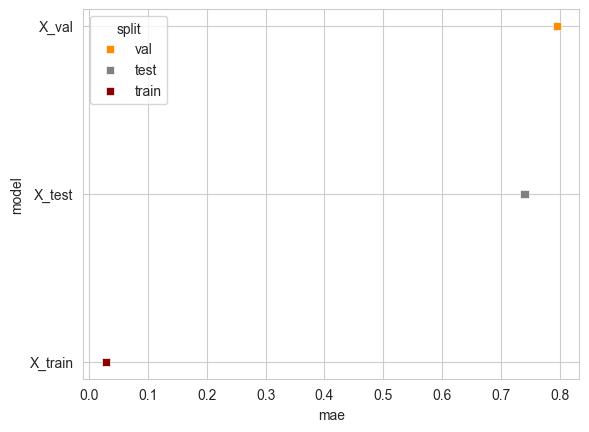

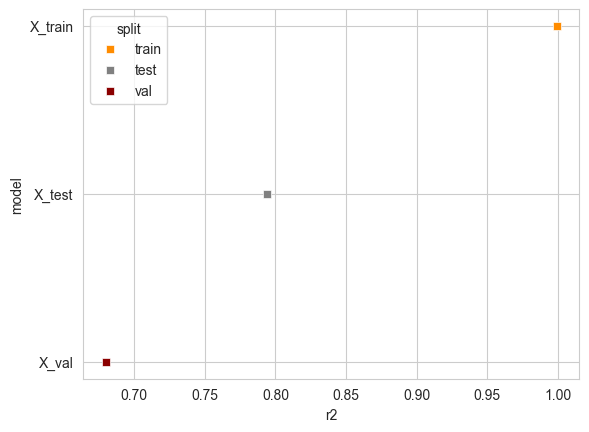

In [39]:
sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mape', ascending=False), 
                y='model', 
                x='mape', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

sns.set_style('whitegrid')
sns.scatterplot(data=perf_df.sort_values(by='r2', ascending=False), 
                y='model', 
                x='r2', 
                marker='s', 
                hue='split', palette=['darkorange', 'grey', 'darkred'])
plt.show()

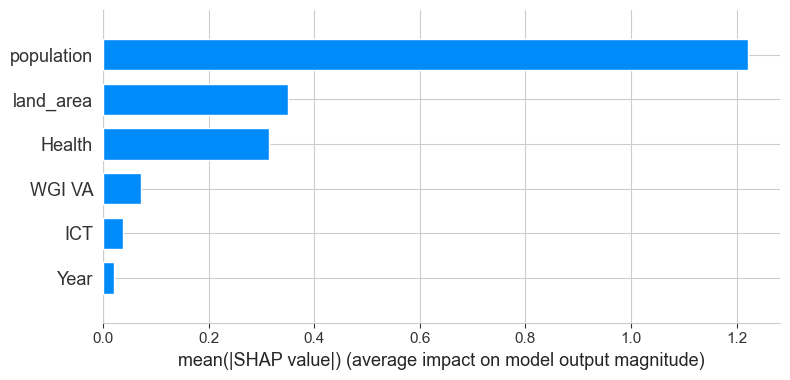

In [40]:
# Calculate SHAP values
explainer = shap.TreeExplainer(merf.trained_fe_model)  # Assuming the fixed effects model is a tree-based model
shap_values = explainer.shap_values(X_train_selected)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_train_selected, plot_type="bar")